In [ ]:
# !gcloud auth login
# !gcloud auth application-default login
# !pip install --upgrade google-cloud-aiplatform protobuf

In [1]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part, GenerationConfig
from vertexai.preview import generative_models
import asyncio

# Initialize Vertex AI
vertexai.init()

# Load the model
multimodal_model = GenerativeModel("gemini-pro")

# Config
config = GenerationConfig(
    candidate_count=1,
    max_output_tokens=1024,
    temperature=0.0
)

safety_config = {
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_NONE,
}

# Query the model
response = multimodal_model.generate_content("who are you?", generation_config=config, safety_settings=safety_config)
# print(response)
print(response.candidates[0].content.parts[0]._raw_part.text)
# print(response.text)

# Multiple inputs
test_inputs = ["What is the capital of Norway?", "Who are you?"]

tasks = [multimodal_model.generate_content_async(x, generation_config=config, safety_settings=safety_config) for x in test_inputs]
outputs = await asyncio.gather(*tasks)

for o in outputs:
    print(o.candidates[0].content.parts[0]._raw_part.text)

I am Gemini, a multimodal AI language model developed by Google. I am designed to understand and generate human language, answer questions, and provide information on a wide range of topics. I am trained on a massive dataset of text and code, which allows me to communicate and perform various language-related tasks effectively.
Oslo
I am Gemini, a multimodal AI language model developed by Google. I am designed to understand and generate human language, answer questions, and provide information on a wide range of topics.


In [ ]:
# Load messages
import pandas as pd
import numpy as np
from datetime import timedelta

# Load messages
msg = pd.read_csv('../../output/cleaned_messages_feb2024.csv', 
                  usecols=['pat_mrn_id', 'message_id', 'create_time', 'myc_mesg_subject', 'to_pat_yn', 'combined_text'])
print(msg.shape)

# Label Messages with Gemini

In [ ]:
# Full Prompt
def gen_labeling_prompt(m):
    return f"""You are an AI assistant who extracts structured JSON from messages sent by clinicians to patients with diabetes. 

* First identify whether the message recommends changing insulin (recommends_insulin_dose_change).
* If the message recommends an insulin change, label whether it is a basal / long acting insulin change (recommends_changing_basal_or_long_acting_insulin), a reminder to take correction doses (recommends_more_correction_doses), whether it adjusts the carb ratio at meal time (recommends_changing_carb_ratio), or if it has a reminder to bolus before meals (reminds_patient_to_bolus).
* Then identify the targets of the message, which can include nighttime glucose (recommends_insulin_change_at_night), daytime/mealtime glucose (recommends_insulin_change_during_the_day), high glucose or low time in range (recommendations_target_high_glucose_or_low_time_in_range), or low glucose (recommendations_target_low_glucose).
* Finally, determine if the message mentiones a recent visit (mentions_recent_visit), or knowledge of the patient's schedule (mentions_patient_schedule).

The output should be JSON with this structure:
{{
recommends_insulin_dose_change: True or False,
recommends_changing_basal_or_long_acting_insulin:  True or False,
recommends_more_correction_doses:  True or False,
recommends_changing_carb_ratio:  True or False,
reminds_patient_to_bolus:  True or False,
recommends_insulin_change_at_night: True or False,
recommends_insulin_change_during_the_day: True or False,
recommendations_target_high_glucose_or_low_time_in_range:  True or False,
recommendations_target_low_glucose:  True or False,
mentions_recent_visit: True or False,
mentions_patient_schedule: True or False
}}

input: Looking at trends this past week compared to the previous week your average increased from 135 to 245. Has anything changed in your routine? Any insights into your daily routine would help me recommend dose changes. For now, I have decreased your bedtime correction target to 150. By giving correction insulin before bed we can help keep you in target range overnight. I would like to make further recommendation to help bring you down to target range more often , but again can you provide insights into your schedule ? How many times per day are you dosing insulin ? Are you giving insulin for both carbs and glucose level at mealtime?
output: {{
recommends_insulin_dose_change: True,
recommends_changing_basal_or_long_acting_insulin: False,
recommends_more_correction_doses:  True,
recommends_changing_carb_ratio:  False,
reminds_patient_to_bolus:  False,
recommends_insulin_change_at_night: True,
recommends_insulin_change_during_the_day: False,
recommendations_target_high_glucose_or_low_time_in_range:  True,
recommendations_target_low_glucose:  False,
mentions_recent_visit: False,
mentions_patient_schedule: False
}}



input: Overall things look great! I want <NAME> to increase his long acting insulin from 12 units to 13 units to help bring his average down just a bit.
output: {{
recommends_insulin_dose_change: True,
recommends_changing_basal_or_long_acting_insulin: True,
recommends_more_correction_doses:  False,
recommends_changing_carb_ratio:  False,
reminds_patient_to_bolus:  False,
recommends_insulin_change_at_night: False,
recommends_insulin_change_during_the_day: False,
recommendations_target_high_glucose_or_low_time_in_range:  True,
recommendations_target_low_glucose:  False,
mentions_recent_visit: False,
mentions_patient_schedule: False
}}

input: This is not a common symptom I hear about but it might be how his body manifests lows. I would like to decrease his long acting insulin from 12 to 10 units to try to avoid some of the lows he is havin.
output: {{
recommends_insulin_dose_change: True,
recommends_changing_basal_or_long_acting_insulin: True,
recommends_more_correction_doses: False,
recommends_changing_carb_ratio: False,
reminds_patient_to_bolus: False,
recommends_insulin_change_at_night: False,
recommends_insulin_change_during_the_day: False,
recommendations_target_high_glucose_or_low_time_in_range: False,
recommendations_target_low_glucose: True,
mentions_recent_visit: False,
mentions_patient_schedule: False
}}

input: It was so good to see all of you on the appt today.
output: {{
recommends_insulin_dose_change: False,
recommends_changing_basal_or_long_acting_insulin: False,
recommends_more_correction_doses: False,
recommends_changing_carb_ratio: False,
reminds_patient_to_bolus: False,
recommends_insulin_change_at_night: False,
recommends_insulin_change_during_the_day: False,
recommendations_target_high_glucose_or_low_time_in_range: False,
recommendations_target_low_glucose: False,
mentions_recent_visit: True,
mentions_patient_schedule: False
}}

input: We can see what happens with 6 units and her soccer schedule.
output: {{
recommends_insulin_dose_change: True,
recommends_changing_basal_or_long_acting_insulin: False,
recommends_more_correction_doses: False,
recommends_changing_carb_ratio: False,
reminds_patient_to_bolus: False,
recommends_insulin_change_at_night: False,
recommends_insulin_change_during_the_day: False,
recommendations_target_high_glucose_or_low_time_in_range: False,
recommendations_target_low_glucose: False,
mentions_recent_visit: False,
mentions_patient_schedule: True
}}

input: {m}
output:
"""

print(msg.combined_text.values[17])
response = multimodal_model.generate_content(
    gen_labeling_prompt(msg.combined_text.values[17]),
    generation_config=config, safety_settings=safety_config)
print(response.candidates[0].content.parts[0]._raw_part.text)

In [5]:
async def gen_message_labels_async_with_timeout(m, to):
    try:
        result = await asyncio.wait_for(multimodal_model.generate_content_async(gen_labeling_prompt(m), generation_config=config, safety_settings=safety_config), timeout=to)
        return(result.candidates[0].content.parts[0]._raw_part.text)
    except asyncio.TimeoutError as e:
        print("Time out")
        return("Error")
    except Exception as e:
        print(e)
        return("Error")


await gen_message_labels_async_with_timeout("Test", 10)

'{\nrecommends_insulin_dose_change: False,\nrecommends_changing_basal_or_long_acting_insulin: False,\nrecommends_more_correction_doses: False,\nrecommends_changing_carb_ratio: False,\nreminds_patient_to_bolus: False,\nrecommends_insulin_change_at_night: False,\nrecommends_insulin_change_during_the_day: False,\nrecommendations_target_high_glucose_or_low_time_in_range: False,\nrecommendations_target_low_glucose: False,\nmentions_recent_visit: False,\nmentions_patient_schedule: False\n}'

In [7]:
# Label all the messages
import time

msg['label_json'] = ''

batch_size = 100
total_batches = -(msg.shape[0] // -batch_size)
print(f"total_batches={total_batches}")

start_index = 0
for i in range(start_index, len(msg), batch_size):
    print(f"{i}/{len(msg)-1}")
    slc = msg.iloc[i : i + batch_size]
    tasks = [gen_message_labels_async_with_timeout(x, 60) for x in slc.combined_text.to_list()]
    start_t = time.time()
    outputs = await asyncio.gather(*tasks)
    msg.iloc[i : i + batch_size, msg.columns.get_loc('label_json')] = outputs
    elapsed_t = time.time() - start_t
    print(f"elapsed = {elapsed_t}")
    # Add wait to ensure at least 60 seconds between batches of 300 requests to API
    time.sleep(max(1, 1 + batch_size/300*60 - elapsed_t))

total_batches=253
0/25220
elapsed = 5.1700439453125
100/25220
elapsed = 4.18927264213562
200/25220
elapsed = 4.3234241008758545
300/25220
elapsed = 3.737291097640991
400/25220
elapsed = 3.0935442447662354
500/25220
elapsed = 3.386108160018921
600/25220
elapsed = 4.304565906524658
700/25220
elapsed = 4.268005132675171
800/25220
elapsed = 3.297272205352783
900/25220
elapsed = 4.484879016876221
1000/25220
elapsed = 3.588088035583496
1100/25220
elapsed = 3.533564805984497
1200/25220
elapsed = 4.004999160766602
1300/25220
elapsed = 3.9045019149780273
1400/25220
elapsed = 3.358250856399536
1500/25220
elapsed = 3.764514923095703
1600/25220
elapsed = 3.508817195892334
1700/25220
elapsed = 3.2475428581237793
1800/25220
elapsed = 4.343827247619629
1900/25220
elapsed = 4.097785711288452
2000/25220
elapsed = 3.5647361278533936
2100/25220
elapsed = 3.153604745864868
2200/25220
elapsed = 3.420912742614746
2300/25220
elapsed = 4.582304000854492
2400/25220
elapsed = 3.3753368854522705
2500/25220
elaps

In [8]:
# Run missing messages with slightly longer timeout

missing_indices = msg.index[(msg.label_json=="Error") | (msg.label_json=="")].tolist()
print(len(missing_indices))

c = 0
while len(missing_indices)>0 and c<3:
    c+=1
    missing_indices = msg.index[(msg.label_json=="Error") | (msg.label_json=="")].tolist()
    print(len(missing_indices))

    for i, idx in enumerate(missing_indices):
        print(f"{i}/{len(missing_indices)-1}")
        output = await gen_message_labels_async_with_timeout(msg.loc[idx, 'combined_text'], 60)
        msg.loc[idx, 'label_json'] = output

5
5
0/4
400 Request contains an invalid argument.
1/4
2/4
3/4
4/4
1
0/0
400 Request contains an invalid argument.
1
0/0
400 Request contains an invalid argument.


In [9]:
# Save messages and labels
msg.to_csv('../../output/gemini_labeled_messages.csv', index=False)

In [10]:
msg.label_json\
    .str.replace('\n','')\
    .str.replace("{",'{"')\
    .str.replace(":",'":')\
    .str.replace(",",', "')\
    .str.replace("False",'"False"')\
    .str.replace("True",'"True"')\
    .values[0]

'{"recommends_insulin_dose_change": "False", "recommends_changing_basal_or_long_acting_insulin": "False", "recommends_more_correction_doses": "False", "recommends_changing_carb_ratio": "False", "reminds_patient_to_bolus": "False", "recommends_insulin_change_at_night": "False", "recommends_insulin_change_during_the_day": "False", "recommendations_target_high_glucose_or_low_time_in_range": "False", "recommendations_target_low_glucose": "False", "mentions_recent_visit": "False", "mentions_patient_schedule": "False"}'

In [11]:
# Parse labels
import json
labels = msg.label_json\
    .str.replace('\n','')\
    .str.replace("{",'{"')\
    .str.replace(":",'":')\
    .str.replace(",",', "')\
    .str.replace("False",'"False"')\
    .str.replace("True",'"True"')\
    .values
message_ids = msg.message_id.values

labels_dicts = []

for l, m in zip(labels, message_ids):
    try:
        d = json.loads(l)
        d['message_id'] = m
        labels_dicts.append(d)
        # print('success')
    except Exception as e:
        print("Parsing error")
        # print(e)
        # print(l)
        labels_dicts.append(json.loads('{"recommends_insulin_dose_change": "False", "recommends_changing_basal_or_long_acting_insulin": "False", "recommends_more_correction_doses": "False", "recommends_changing_carb_ratio": "False", "reminds_patient_to_bolus": "False", "recommends_insulin_change_at_night": "False", "recommends_insulin_change_during_the_day": "False", "recommendations_target_high_glucose_or_low_time_in_range": "False", "recommendations_target_low_glucose": "False", "message_id":"' + str(m) + '"}'))
        print("––––––––––––––––––––––––––––––––")


# Convert to DataFrame
label_dicts_df = pd.DataFrame(labels_dicts)
label_dicts_df

Parsing error
––––––––––––––––––––––––––––––––


,recommends_insulin_dose_change,recommends_changing_basal_or_long_acting_insulin,recommends_more_correction_doses,recommends_changing_carb_ratio,reminds_patient_to_bolus,recommends_insulin_change_at_night,recommends_insulin_change_during_the_day,recommendations_target_high_glucose_or_low_time_in_range,recommendations_target_low_glucose,mentions_recent_visit,mentions_patient_schedule,message_id
0,False,False,False,False,False,False,False,False,False,False,False,5231804
1,False,False,False,False,False,False,False,False,False,False,False,5234821
2,False,False,False,False,False,False,False,False,False,False,False,5234838
3,False,False,False,False,False,False,False,False,False,False,False,5236960
4,False,False,False,False,False,False,False,False,False,False,False,5237707
...,...,...,...,...,...,...,...,...,...,...,...,...
25216,False,False,False,False,False,False,False,False,False,True,False,20787688
25217,False,False,False,False,False,False,False,True,True,False,False,20989731
25218,False,False,False,False,False,False,False,False,False,True,True,21237004
25219,False,False,False,False,False,False,False,False,False,False,False,21237069


In [ ]:
# Join with data

msg_labels = msg.merge(label_dicts_df, on='message_id')
msg_labels.describe(include='all')

In [13]:
# Save messages and labels
msg_labels.to_csv('../../output/gemini_labeled_messages_extracted.csv', index=False)

In [18]:
msg_labels = msg_labels.replace({'True':True, 'False':False})
msg_labels[msg_labels.columns[7:]].agg(['mean','sum'])

,recommends_insulin_dose_change,recommends_changing_basal_or_long_acting_insulin,recommends_more_correction_doses,recommends_changing_carb_ratio,reminds_patient_to_bolus,recommends_insulin_change_at_night,recommends_insulin_change_during_the_day,recommendations_target_high_glucose_or_low_time_in_range,recommendations_target_low_glucose,mentions_recent_visit,mentions_patient_schedule
mean,0.179342,0.103331,0.041118,0.071174,0.046273,0.111102,0.090404,0.16586,0.153093,0.059873,0.060309
sum,4523.000000,2606.000000,1037.000000,1795.000000,1167.000000,2802.000000,2280.000000,4183.00000,3861.000000,1510.000000,1521.000000


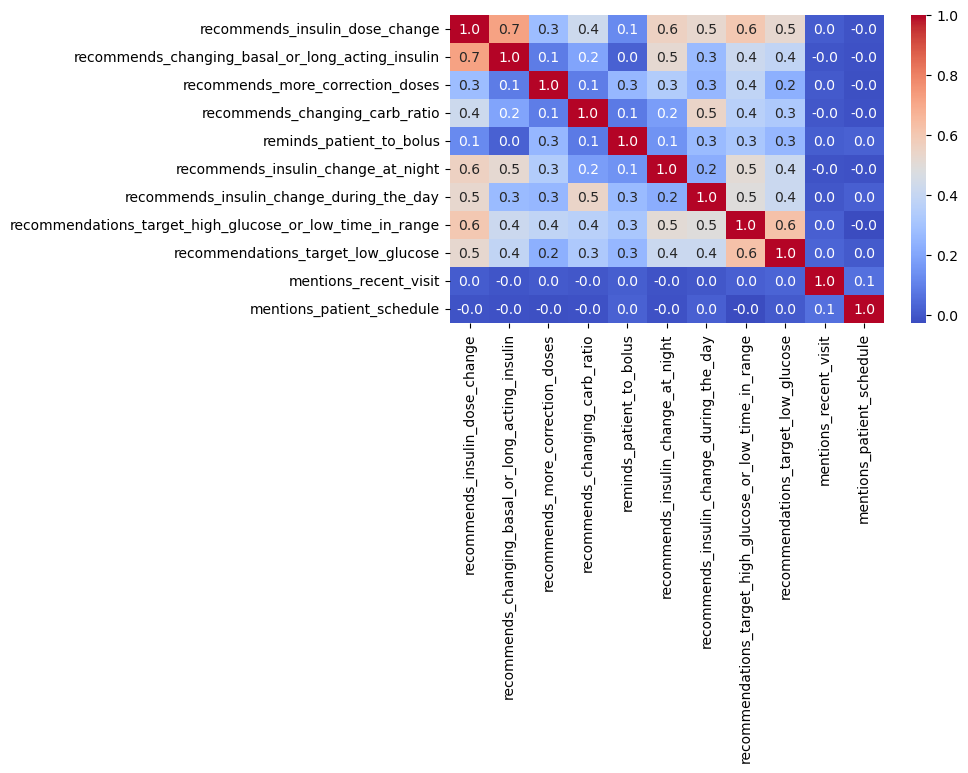

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = msg_labels[msg_labels.columns[7:]].corr()

# Create a heatmap
plt.figure(figsize=(7, 4))  # You can adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")

# Show the plot
plt.show()

# Look at example messages with labels to evaluate precision

In [ ]:
for cn in msg_labels.columns[7:]:
    print(cn)
    print(msg_labels[msg_labels[cn]].combined_text.values[0])
    print("–"*100)